# EDA

## Environment

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Change main system path to be able to run code from src folder
import sys
p = sys.path[0]
# Mac OS
if sys.path[0].endswith('/notebooks'):
    main_path = p[:-len('/notebooks')]
if sys.path[0].endswith('/techdoc/content'):
    main_path = p[:-len('/techdoc/content')]
    
# Windows OS
if sys.path[0].endswith('\\notebooks'): 
    main_path = p[:-len('\\notebooks')]
if sys.path[0].endswith('\\techdoc\content'): 
    main_path = p[:-len('\\techdoc\content')]

sys.path[0] = main_path

In [3]:
import gc, itertools
from termcolor import colored
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src import (config, describe_data, features,
                 preprocess, training)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load the Data

In [4]:
metadata = pd.read_csv(config.DATA_DIR + 'metadata.csv')
print(f'Metadata: {metadata.shape}')

train_labels = pd.read_csv(config.DATA_DIR + 'train_labels.csv')
print(f'Train labels: {train_labels.shape}')

valid_labels = pd.read_csv(config.DATA_DIR + 'val_labels.csv')
print(f'Train labels: {valid_labels.shape}')

submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv')
print(f'Submission: {submission.shape}')

Metadata: (1570, 5)
Train labels: (766, 11)
Train labels: (293, 11)
Submission: (804, 11)


In [5]:
# ===== FILE PATHS OF SAMPLES =====
train_files = metadata[metadata.split == 'train']['features_path'].to_dict()
valid_files = metadata[metadata.split == 'val']['features_path'].to_dict()
test_files = metadata[metadata.split == 'test']['features_path'].to_dict()
# Train & Valid files
trva_files = train_files.copy()
trva_files.update(valid_files)
# All files
all_test_files = valid_files.copy()
all_test_files.update(test_files)

ion_list = list(np.arange(0,100,1.0))
ion_list.remove(4.0)

# Get the names of the target columns in a list
target_labels_list = [i for i in train_labels.columns if i not in ['sample_id']]
print(target_labels_list)

['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']


In [6]:
train = metadata[metadata.split == 'train'].copy().reset_index(drop=True)
print(f'TRAIN: {train.shape}')
valid = metadata[metadata.split == 'val'].copy().reset_index(drop=True)
print(f'VALID: {valid.shape}')
test = metadata[metadata.split == 'test'].copy().reset_index(drop=True)
print(f'TEST: {test.shape}')

TRAIN: (766, 5)
VALID: (293, 5)
TEST: (511, 5)


# Class weight for logistic

In [11]:
for label in target_labels_list:
    print(f'{label}: {np.round(train_labels[label].sum()/train_labels.shape[0],4)}')

basalt: 0.1188
carbonate: 0.1279
chloride: 0.1214
iron_oxide: 0.2206
oxalate: 0.0392
oxychlorine: 0.235
phyllosilicate: 0.3172
silicate: 0.1358
sulfate: 0.1945
sulfide: 0.047


# Analysis of time series

- Percentage change in relative abundance per temp-ion - For each temperature(bin)-ion combination compute the change in relativen abundance.
- find number of peaks
- area under the curve for each ion type

### Hands-On Analysis

- add ion_cnt_peaks
- add time to peak
- first bigger than second if more than one

Refernces:  
- [finding peaks in MS data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2631518/)
- [SO comment on scipy](https://stackoverflow.com/questions/1713335/peak-finding-algorithm-for-python-scipy)

In [12]:
i = 0
ht = preprocess.get_sample(metadata,i)
ht = preprocess.preprocess_samples(ht, detrend_method='min')

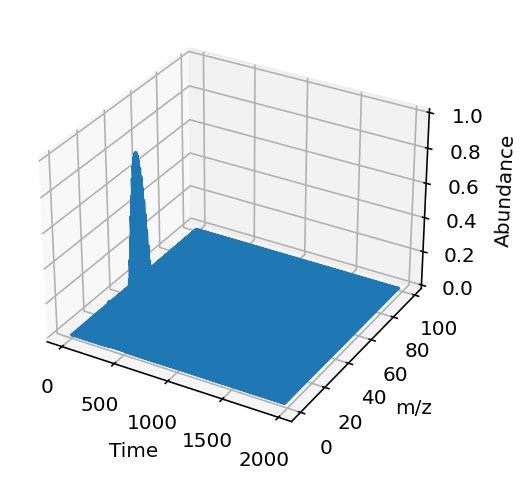

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = ht['time']
z = ht['abun_scaled']
y = ht['m/z']

ax.set_xlabel("Time")
ax.set_zlabel("Abundance")
ax.set_ylabel("m/z")

ax.plot(x, y, z)

plt.show()

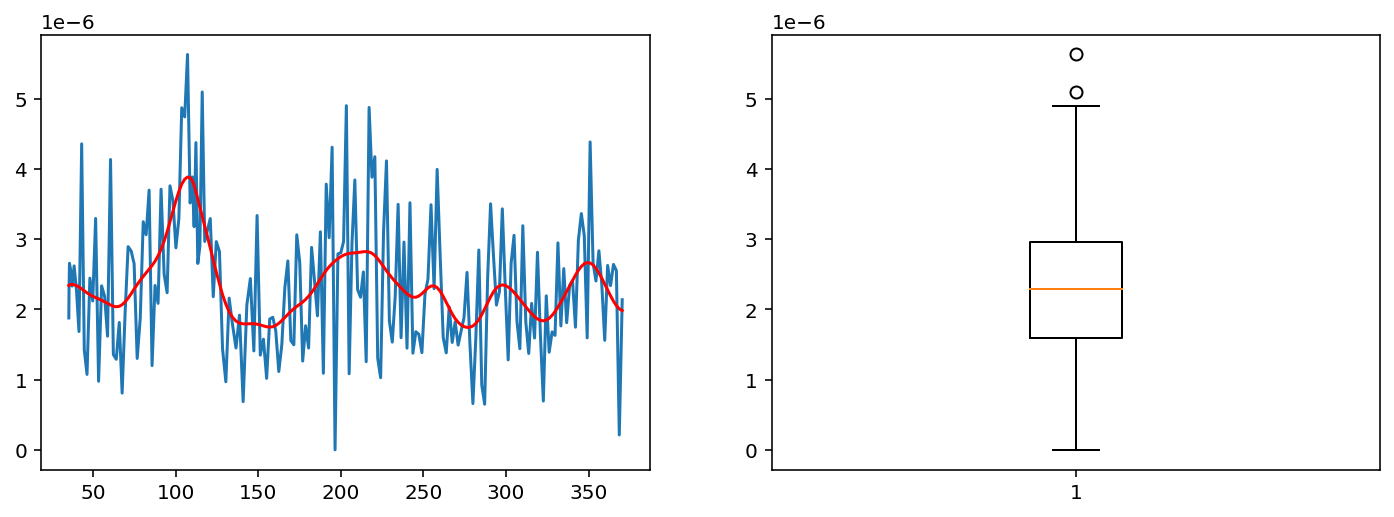

In [ ]:
htt = ht[ht['m/z'] == 9.0].copy()
htt['abun_minsub_scaled_filtered'] = gaussian_filter1d(htt['abun_minsub_scaled'], sigma=4)

fig, ax = plt.subplots(1,2, figsize=(12,4))
plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abun_minsub_scaled'])
plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abun_minsub_scaled_filtered'], color='red')
plt.subplot(1, 2, 2); plt.boxplot(htt['abun_minsub_scaled'])
plt.show()

In [ ]:
ion_abund_median = htt['abun_minsub_scaled_filtered'].mean()
print(ion_abund_median)
peaks, _ = find_peaks(htt['abun_minsub_scaled_filtered'], prominence=ion_abund_median)
#peaks_s = find_peaks_cwt(htt['abun_minsub_scaled'], noise_perc=0.1)
print(f'Peak idx: {peaks}') # indexes where peaks are found
#print(f'Peak idx: {peaks_s}') # indexes where peaks are found
# Get temp values for peaks
for i in peaks:
    print(htt.iloc[i]['temp'])
    
# Compute area under the curve
#xx = htt['temp']
#yy = htt['abun_minsub_scaled']
#print(f'Area under the curve: {np.round(auc(xx,yy),5)}')

2.360300874910426e-06
Peak idx: []


In [ ]:
# Computation for sample S0000
ion_peaks_cnt = {}

for ion in ion_list:
    ion_peaks_info = []
    temp_dt = ht[ht['m/z'] == ion].copy()
    temp_dt['abun_minsub_scaled_filtered'] = gaussian_filter1d(temp_dt['abun_minsub_scaled'], 
                                                               sigma=4)
    med = temp_dt['abun_minsub_scaled_filtered'].median()
    
    peaks, _ = find_peaks(temp_dt['abun_minsub_scaled_filtered'], prominence=med)
    ion_peaks_info.append(len(peaks))
    
    peak_temp = []
    peak_time = []
    peak_abund = []
    for i in peaks:
        tm = temp_dt.iloc[i]['time']; peak_time.append(tm) 
        t = temp_dt.iloc[i]['temp']; peak_temp.append(t)
        a = temp_dt.iloc[i]['abun_minsub_scaled']; peak_abund.append(a)
    
    if len(peak_time)>0 and len(peak_temp)>0 and len(peak_abund)>0:
        peak_time = max(peak_time)
        peak_temp = max(peak_temp)
        peak_abund = max(peak_abund)
    else: 
        peak_time, peak_temp, peak_abund = 0, 0, 0
        
    # Compute AUC
    if not temp_dt.empty:
        area_abund = np.round(auc(temp_dt['temp'],temp_dt['abun_minsub_scaled']),5)
    else: area_abund = 0
    
    # Add values
    ion_peaks_info.append(peak_time)
    ion_peaks_info.append(peak_temp)
    ion_peaks_info.append(peak_abund)
    ion_peaks_info.append(area_abund)
        
    ion_peaks_cnt[ion] = ion_peaks_info
    
ion_peaks_cnt

{0.0: [2, 1057.428, 211.921, 0.004470519521099676, 0.23782],
 1.0: [2, 1057.428, 211.921, 0.0038136619698634225, 0.21449],
 2.0: [2, 1077.961, 215.359, 0.0005123556598944679, 0.03806],
 3.0: [0, 0, 0, 0, 0.03961],
 5.0: [1, 441.332, 105.458, 2.7124405884896144e-05, 0.00385],
 6.0: [1, 431.06, 103.666, 2.6798565682232838e-06, 0.00084],
 7.0: [1, 420.772, 101.931, 4.246513336702777e-06, 0.0006],
 8.0: [0, 0, 0, 0, 0.00104],
 9.0: [0, 0, 0, 0, 0.00078],
 10.0: [0, 0, 0, 0, 0.00082],
 11.0: [0, 0, 0, 0, 0.00084],
 12.0: [2, 1796.886, 340.303, 0.00014395089424569068, 0.01731],
 13.0: [0, 0, 0, 0, 0.00402],
 14.0: [0, 0, 0, 0, 0.38302],
 15.0: [2, 1077.961, 215.359, 0.00023548035042686977, 0.01611],
 16.0: [2, 1057.428, 211.921, 0.024268038610332734, 1.2762],
 17.0: [2, 1057.428, 211.921, 0.2731880287813971, 13.32941],
 18.0: [2, 1057.428, 211.921, 0.9858801583853227, 48.16406],
 19.0: [2, 1088.232, 217.115, 0.006349436036159307, 0.46937],
 20.0: [2, 1057.428, 211.921, 0.002035174175259523, 

In [ ]:
new_cols = ['m/z','peak_cnt', 'peak_time', 'peak_temp', 'peak_abund', 'abund_area']
ion_peaks_stats = pd.DataFrame(ion_peaks_cnt)
ion_peaks_stats = ion_peaks_stats.T
ion_peaks_stats.reset_index(inplace=True)
ion_peaks_stats.columns = new_cols
ion_peaks_stats['sample_id'] = 'S0000'
ion_peaks_stats

,m/z,peak_cnt,peak_time,peak_temp,peak_abund,abund_area,sample_id
0,0.0,2.0,1057.428,211.921,0.004471,0.23782,S0000
1,1.0,2.0,1057.428,211.921,0.003814,0.21449,S0000
2,2.0,2.0,1077.961,215.359,0.000512,0.03806,S0000
3,3.0,0.0,0.000,0.000,0.000000,0.03961,S0000
4,5.0,1.0,441.332,105.458,0.000027,0.00385,S0000
...,...,...,...,...,...,...,...
94,95.0,0.0,0.000,0.000,0.000000,0.00049,S0000
95,96.0,0.0,0.000,0.000,0.000000,0.00074,S0000
96,97.0,0.0,0.000,0.000,0.000000,0.00052,S0000
97,98.0,0.0,0.000,0.000,0.000000,0.00050,S0000


In [ ]:
features.compute_ion_peaks(metadata, 0, ion_list)

peak_cnt                                               ...  \
m/z           0.0  1.0  2.0  3.0  5.0  6.0  7.0  8.0  9.0  10.0  ...   
sample_id                                                        ...   
S0000          2.0  2.0  2.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  ...   

          peak_abund                                               
m/z             90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0 98.0 99.0  
sample_id                                                          
S0000            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 396 columns]

In [ ]:
file_paths = {A:N for (A,N) in [x for x in train_files.items()][:5]}
ita = features.features_ion_peaks(file_paths, metadata, ion_list)
ita

100%|██████████| 5/5 [00:00<00:00,  6.10it/s]


,peak_cnt_0.0,peak_cnt_1.0,peak_cnt_2.0,peak_cnt_3.0,peak_cnt_5.0,peak_cnt_6.0,peak_cnt_7.0,peak_cnt_8.0,peak_cnt_9.0,peak_cnt_10.0,...,peak_abund_90.0,peak_abund_91.0,peak_abund_92.0,peak_abund_93.0,peak_abund_94.0,peak_abund_95.0,peak_abund_96.0,peak_abund_97.0,peak_abund_98.0,peak_abund_99.0
sample_id,,,,,,,,,,,,,,,,,,,,,
S0000,2.0,2.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0002,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0003,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0004,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Loess Smooth

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [ ]:
htt = ht[ht['m/z'] == 18.0].copy()

In [ ]:
htt.head(2)

,time,temp,m/z,abun_minsub_scaled
18,0.000,35.289,18.0,0.001415
218,10.251,35.420,18.0,0.001365


In [ ]:
htt['abund_ma'] = htt['abun_minsub_scaled'].rolling(3, center=True, closed='both').mean()
htt['abund_loess6'] = pd.DataFrame(lowess(htt['abun_minsub_scaled'], 
                                          np.arange(len(htt['abun_minsub_scaled'])), 
                                          frac=0.15)[:, 1], index=htt.index, columns=['abun_minsub_scaled'])
htt['abund_gauss'] = gaussian_filter1d(htt['abun_minsub_scaled'], sigma=4)

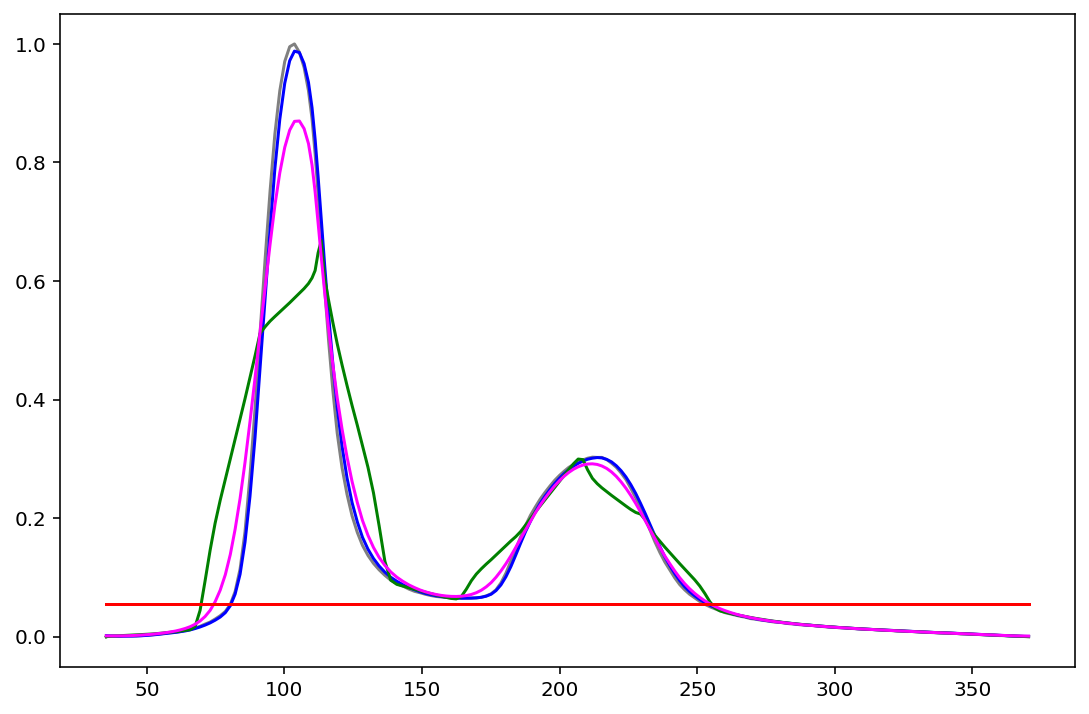

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abun_minsub_scaled'], c='grey')
plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abund_ma'], c='blue')
plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abund_loess6'], c='green')
plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abund_gauss'], c='magenta')
plt.subplot(1, 2, 1); plt.plot([htt['temp'].min(), htt['temp'].max()], 
                               [htt['abun_minsub_scaled'].median(), htt['abun_minsub_scaled'].median()], 
                               c='red')

#plt.subplot(1, 2, 2); plt.boxplot(htt['abund_loess6'])
plt.show()

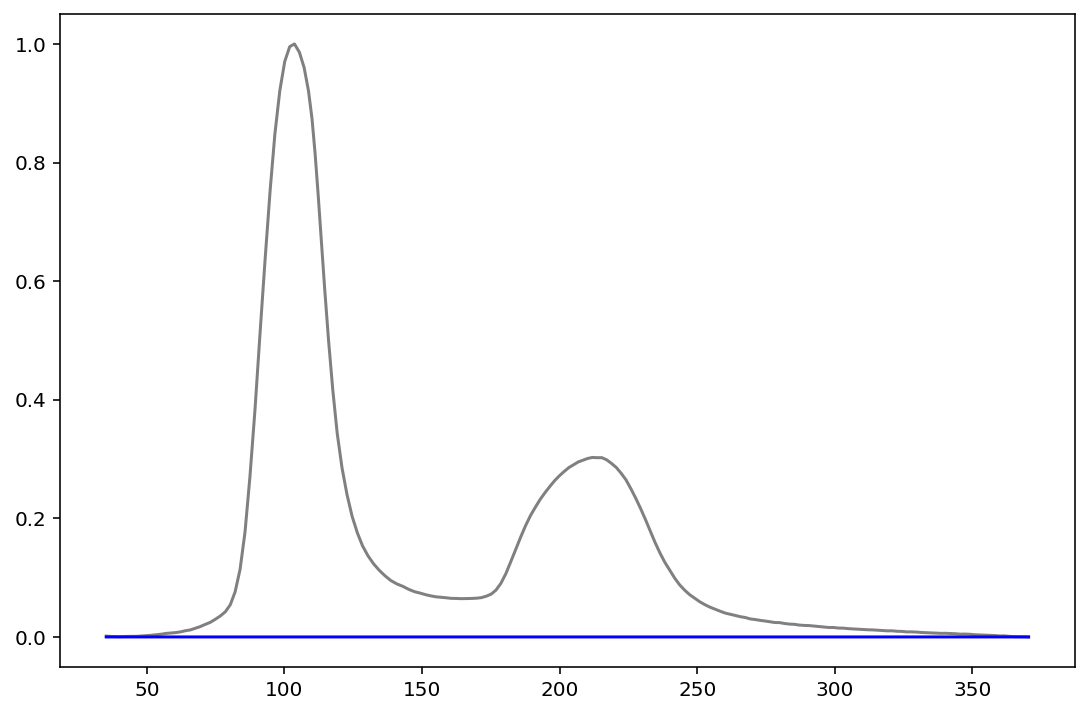

In [ ]:
htt1 = ht[ht['m/z'] == 10.0].copy()
fig, ax = plt.subplots(1,1, figsize=(20,6))
plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abun_minsub_scaled'], c='grey')
plt.subplot(1, 2, 1); plt.plot(htt1['temp'], htt1['abun_minsub_scaled'], c='blue')
#plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abund_ma'], c='blue')
#plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abund_loess6'], c='green')
#plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abund_gauss'], c='magenta')
#plt.subplot(1, 2, 1); plt.plot([htt['temp'].min(), htt['temp'].max()], 
#                               [htt['abun_minsub_scaled'].median(), htt['abun_minsub_scaled'].median()], 
#                               c='red')

#plt.subplot(1, 2, 2); plt.boxplot(htt['abund_loess6'])
plt.show()

### Abundance Peaks + Stats

In [ ]:
# ===== TRAIN SAMPLE =====
fts_ion_peaks = features.features_ion_peaks(train_files, metadata, ion_list)
print(fts_ion_peaks.shape)
fts_ion_peaks.head()

100%|██████████| 766/766 [02:15<00:00,  5.66it/s]

(766, 396)


,peak_cnt_0.0,peak_cnt_1.0,peak_cnt_2.0,peak_cnt_3.0,peak_cnt_5.0,peak_cnt_6.0,peak_cnt_7.0,peak_cnt_8.0,peak_cnt_9.0,peak_cnt_10.0,...,peak_abund_90.0,peak_abund_91.0,peak_abund_92.0,peak_abund_93.0,peak_abund_94.0,peak_abund_95.0,peak_abund_96.0,peak_abund_97.0,peak_abund_98.0,peak_abund_99.0
sample_id,,,,,,,,,,,,,,,,,,,,,
S0000,2.0,2.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0002,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0003,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0004,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# ===== VALID & TEST SAMPLE =====
fts_ion_peaks_VT = features.features_ion_peaks(all_test_files, metadata, ion_list)
print(fts_ion_peaks_VT.shape)
fts_ion_peaks_VT.head()

100%|██████████| 804/804 [02:35<00:00,  5.18it/s]

(804, 396)


,peak_cnt_0.0,peak_cnt_1.0,peak_cnt_2.0,peak_cnt_3.0,peak_cnt_5.0,peak_cnt_6.0,peak_cnt_7.0,peak_cnt_8.0,peak_cnt_9.0,peak_cnt_10.0,...,peak_abund_90.0,peak_abund_91.0,peak_abund_92.0,peak_abund_93.0,peak_abund_94.0,peak_abund_95.0,peak_abund_96.0,peak_abund_97.0,peak_abund_98.0,peak_abund_99.0
sample_id,,,,,,,,,,,,,,,,,,,,,
S0766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0769,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0770,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Abundance area

In [54]:
i = 595
hts = preprocess.get_sample(metadata, i)
hts = preprocess.preprocess_samples(hts, 'min')
sample_name = metadata.iloc[i]['sample_id']

In [58]:
tempdf = hts[hts['m/z'] == 18.0].copy()
temprange = pd.interval_range(start=-100, end=1500, freq=100)
tempdf['temp_bin'] = pd.cut(tempdf['temp'], bins=temprange)
tempdf

,time,temp,m/z,abun_scaled,temp_bin
18,0.000,62.696,18.0,0.009703,"(0, 100]"
218,10.283,63.011,18.0,0.004384,"(0, 100]"
418,20.554,63.843,18.0,0.001433,"(0, 100]"
618,30.855,65.157,18.0,0.002676,"(0, 100]"
818,41.128,67.020,18.0,0.005152,"(0, 100]"
...,...,...,...,...,...
36018,1852.572,856.404,18.0,0.203492,"(800, 900]"
36218,1862.831,857.398,18.0,0.200254,"(800, 900]"
36418,1873.111,858.437,18.0,0.197168,"(800, 900]"
36618,1883.398,859.442,18.0,0.197207,"(800, 900]"


In [77]:
from sklearn.linear_model import LinearRegression

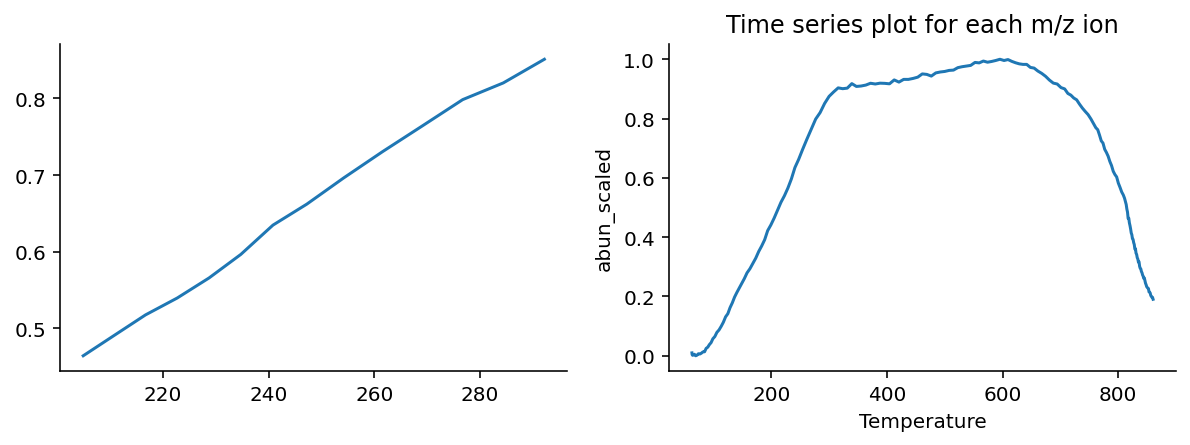

In [118]:
_,_ = plt.subplots(1,2, figsize=(10,3))

plt.subplot(1,2,1)
bin = pd.Interval(200,300, closed='right')
plt.plot(tempdf[tempdf.temp_bin == bin].temp, tempdf[tempdf.temp_bin == bin].abun_scaled)

plt.subplot(1,2,2)
describe_data.plot_mz_ts(hts[hts['m/z'] == 18.0], 'abun_scaled')

plt.show()

In [117]:
dtt = tempdf[tempdf.temp_bin == bin].copy()

# Area of the abundance
dtt = dtt.sort_values(by=['time', 'abun_scaled'])
x = dtt['time'].values
y = dtt['abun_scaled'].values
area = np.trapz(y=y,x=x)

# Get the slope of temp and abundance
dtt = dtt.sort_values(by=['temp', 'abun_scaled'])
lr = LinearRegression()
X = np.array(dtt['temp']).reshape(-1, 1)
y = dtt['abun_scaled'].values
slope = lr.fit(X, y).coef_[0]

print(f'Area: {area}')
print(f'Max abundance : {dtt.abun_scaled.max()}')
print(f'Slope teab: {slope}')

Area: 87.1849312738693
Max abundance : 0.8510391522938565
Slope teab: 0.004564161149902046


In [119]:
i = 595
hts = preprocess.get_sample(metadata, i)
ion_areas = features.bin_temp_area(hts, detrend_method='min')
ion_areas

TypeError: bin_temp_area() missing 1 required positional argument: 'detrend_method'

In [50]:
def tempion_area(df_sample, detrend_method):
    # Create a series of temperature bins
    temprange = pd.interval_range(start=-100, end=1500, freq=100)
    df_sample['temp_bin'] = pd.cut(df_sample['temp'], bins=temprange)
    
    # Preprocess the sample data
    df_sample = preprocess.preprocess_samples(df_sample, 
                                              detrend_method=detrend_method)
    
    # Combine m/z and temp_bin
    df_sample['cat'] = df_sample['m/z'].astype('str') + '_' +  df_sample['temp_bin'].astype('str')

    area_dict = {}
    for n,i in tqdm(enumerate(df_sample['cat'])):
        ion = df_sample.iloc[n]['m/z']
        bin = df_sample.iloc[n]['temp_bin']
        
        temp = df_sample[(df_sample['m/z'] == ion) & 
                            (df_sample['temp_bin'] == bin)]
        temp = temp.sort_values(by=['time', 'abun_scaled'])
        x = df_sample['time'].values
        y = df_sample['abun_scaled'].values
        area = np.trapz(y=y,x=x)
        
        area_dict[i] = area
    
    return area_dict

In [51]:
i = 595
hts = preprocess.get_sample(metadata, i)
#hts = preprocess.preprocess_samples(hts, 'min')
sample_name = metadata.iloc[i]['sample_id']

In [52]:
areas = tempion_area(hts, detrend_method='min') 

18315it [00:55, 332.41it/s]


In [53]:
areas

{'0.0_(0, 100]': 2.307968217904066,
 '1.0_(0, 100]': 2.307968217904066,
 '2.0_(0, 100]': 2.307968217904066,
 '3.0_(0, 100]': 2.307968217904066,
 '5.0_(0, 100]': 2.307968217904066,
 '6.0_(0, 100]': 2.307968217904066,
 '7.0_(0, 100]': 2.307968217904066,
 '8.0_(0, 100]': 2.307968217904066,
 '9.0_(0, 100]': 2.307968217904066,
 '10.0_(0, 100]': 2.307968217904066,
 '11.0_(0, 100]': 2.307968217904066,
 '12.0_(0, 100]': 2.307968217904066,
 '13.0_(0, 100]': 2.307968217904066,
 '14.0_(0, 100]': 2.307968217904066,
 '15.0_(0, 100]': 2.307968217904066,
 '16.0_(0, 100]': 2.307968217904066,
 '17.0_(0, 100]': 2.307968217904066,
 '18.0_(0, 100]': 2.307968217904066,
 '19.0_(0, 100]': 2.307968217904066,
 '20.0_(0, 100]': 2.307968217904066,
 '21.0_(0, 100]': 2.307968217904066,
 '22.0_(0, 100]': 2.307968217904066,
 '23.0_(0, 100]': 2.307968217904066,
 '24.0_(0, 100]': 2.307968217904066,
 '25.0_(0, 100]': 2.307968217904066,
 '26.0_(0, 100]': 2.307968217904066,
 '27.0_(0, 100]': 2.307968217904066,
 '28.0_(0,

# Background Presence

- Some ions have a background presence in the gas passing through in the mass spectrometer.
- **It is shown by a relatively constant non-zero abundance value over the entire run across the temperature range**
- We need to substract this background to clean the data.
- Methods:
    - substract the minimum value of the series from each abundance value
    - fit a line or a polynomial and substract that value.

In [47]:
basalt

Int64Index([ 16,  21,  26,  28,  30,  35,  45,  73,  84,  91,  99, 100, 107,
            109, 112, 117, 122, 133, 149, 153, 159, 163, 171, 174, 177, 181,
            208, 211, 212, 215, 220, 223, 233, 242, 251, 253, 266, 271, 281,
            282, 289, 303, 322, 324, 329, 334, 385, 403, 406, 422, 438, 454,
            459, 462, 464, 474, 489, 491, 500, 507, 509, 514, 517, 521, 534,
            541, 546, 573, 574, 577, 580, 595, 597, 606, 612, 618, 624, 635,
            647, 649, 653, 655, 674, 682, 703, 707, 720, 722, 729, 732, 753],
           dtype='int64')

In [10]:
i = 595
hts = preprocess.get_sample(metadata, i)
hts = preprocess.preprocess_ion_type(hts)
hts = preprocess.detrend_poly(hts)
sample_name = metadata.iloc[i]['sample_id']

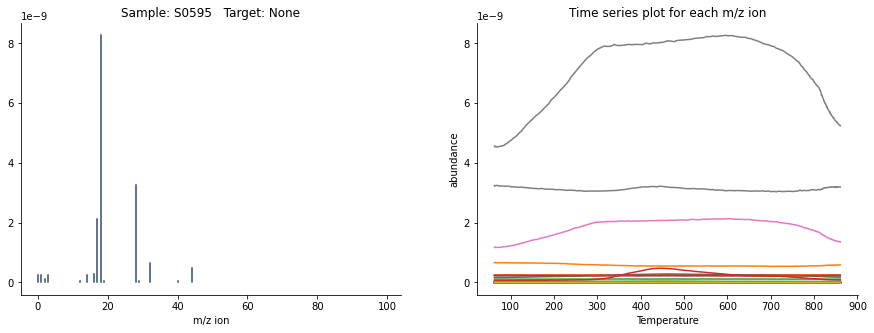

In [63]:
_,_ = plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)
describe_data.plot_ms(hts, sample_id=sample_name, col_to_plot='abundance')
plt.subplot(1,2,2)
describe_data.plot_mz_ts(hts, 'abundance')

## Instrument type

What proportion of instrument type do we have in the train, valid, and test samples? We get the column percentages with `pd.crosstab()` function and the argument `normalize='index'` to get the percentage by rows. We can see from the table below that the most commercial instrument is present in the train set, while in the majority of the SAM measurments are in the test set. Interestingly, there are no SAM measurements in the `val` dataset.

> In this competition, it is expected that modeling the SAM testbed data will be difficult, and that there will need to be transfer learning from the commercial instrument data in order to successfully model the SAM testbed data. 

> The top performers on the SAM testbed samples within the test set will be invited to submit a report of their methodology, to be judged by a panel of experts from NASA. 
([Ref](https://www.drivendata.co/blog/mars-spectrometry-benchmark/))

In [ ]:
#TODO Define the testing of the model on the whole sample using the CV and then separately on the commercial vs SAM instrument.  
#TODO Can it be done to model on commercial only and do a transfer learning on the SAM instrument.

In [7]:
pd.crosstab(metadata.split, metadata.instrument_type, margins=True)

instrument_type,commercial,sam_testbed,All
split,,,
test,447,64,511
train,754,12,766
val,293,0,293
All,1494,76,1570


In [8]:
pd.crosstab(metadata.split, metadata.instrument_type, normalize='index')

instrument_type,commercial,sam_testbed
split,,
test,0.874755,0.125245
train,0.984334,0.015666
val,1.000000,0.000000


In [13]:
# Combine target labels in a list for each sample
labels_list = {}
for i in train_labels.index:
    ht = pd.DataFrame(train_labels.iloc[i][target_labels_list] == 1)
    labels_list[i] = ht[ht[i] == True].index.values

# Map back to the initial table
train_labels['target'] = train_labels.index.map(labels_list)

## Exploring Features

### Time vs. Temperature

- temperature is suppose to be a function of time in the experiments
- patterns of ions may vary as a function of both time and temperature
- instrument type may contain different ranges of times and temperatures

In [ ]:
#TODO how to incorporate the fact that testbeds has some non-linear heating profiles...
# there may be nuances to how the sample was heated over time that provides additional information.

Let's visually explore the relationship between `time` and `temperature` for both types of instruments. We will pick at random 5 samples for each and plot them.

In [9]:
# Randomly select 5 samples from each instrument
sample_com = metadata[(metadata.instrument_type == 'commercial') & (metadata.split == 'train')]['sample_id'].sample(n=5).index
sample_sam = metadata[(metadata.instrument_type == 'sam_testbed') & (metadata.split == 'train')]['sample_id'].sample(n=5).index

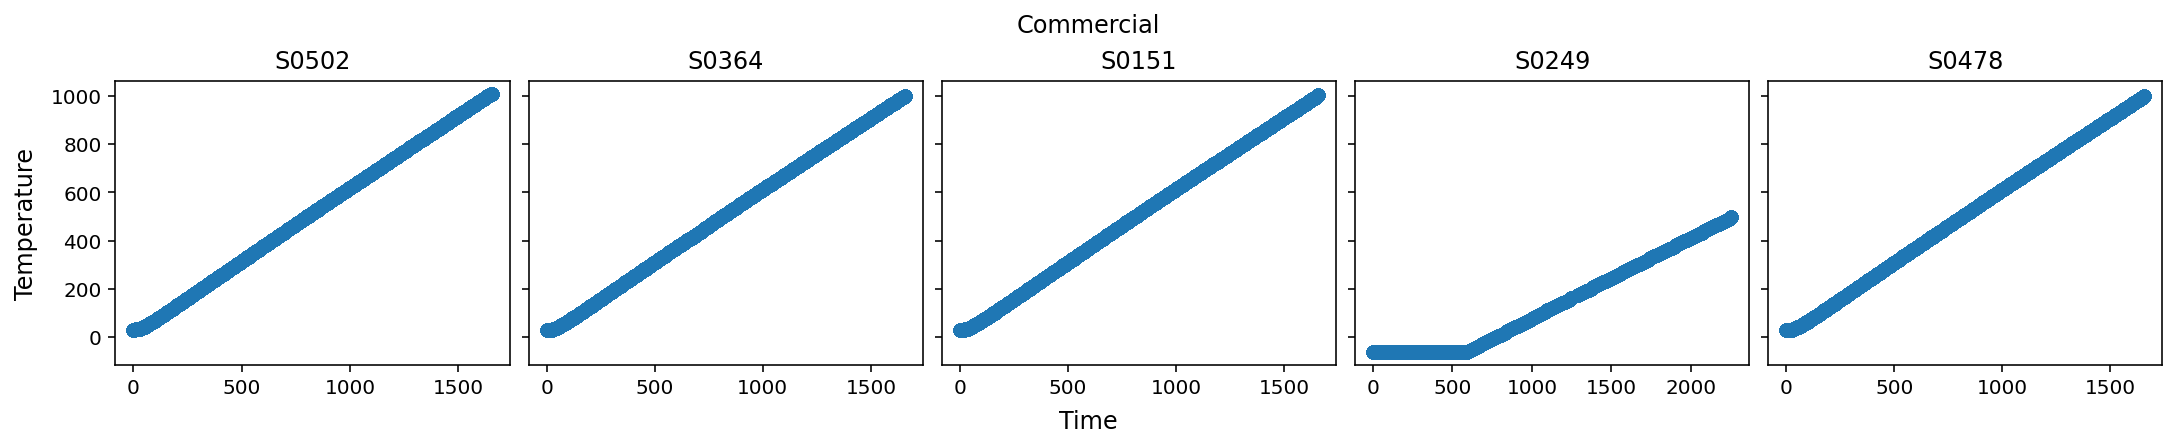

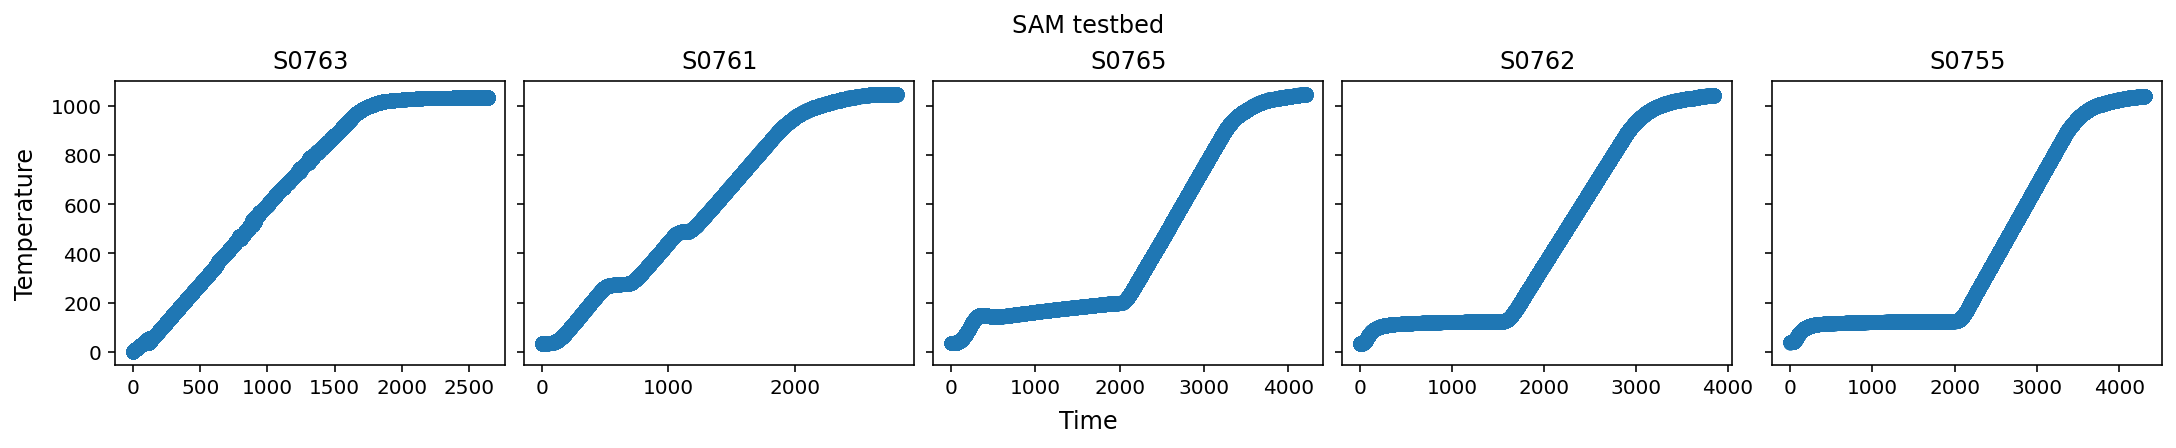

In [10]:
fig, ax = plt.subplots(1, len(sample_com), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Temperature')
fig.supxlabel('Time')
fig.suptitle('Commercial')

for n,i in enumerate(sample_com):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    plt.scatter(df['time'], df['temp'])
    plt.title(sample_name)
plt.show()
    
fig, ax = plt.subplots(1, len(sample_sam), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Temperature')
fig.supxlabel('Time')
fig.suptitle('SAM testbed')

for n,i in enumerate(sample_sam):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    plt.scatter(df['time'], df['temp'])
    plt.title(sample_name)
plt.show()
    

From the graphs above we can see that the sample have similar structure of temperature increase given time, where the max values is about 1000 degrees over a period of 1600 seconds. However, we can see that there is a difference in structure between the two instruments, where the SAM testbed has more of a non-linear structure.

### Type of Ion vs Abundance

Type of ion is given by `m/z` where the abundance, or the ion's type levels across time and temperature, is given by `abundance`. Let's try to visualize the abundance by the type of ions given temperature.

- different ion types peak at different temperatures
- there are some ions that are constantly high is value -> `m/z=4` helium carrier gas (not from the sample)
- there are ion types consistently in low value - likely background abundances and should be neglected.

> Spectrogram is useful for the peaks in abundances it shows at different temperatures and times.

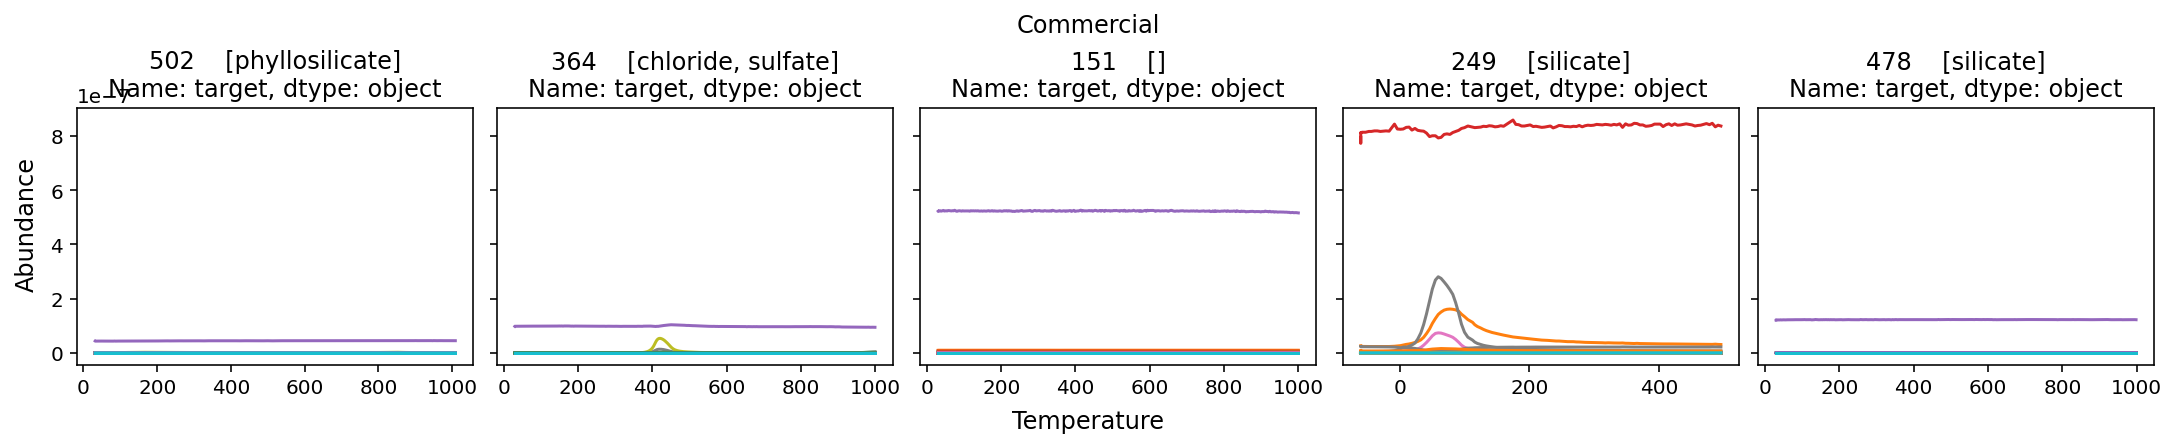

KeyboardInterrupt: 

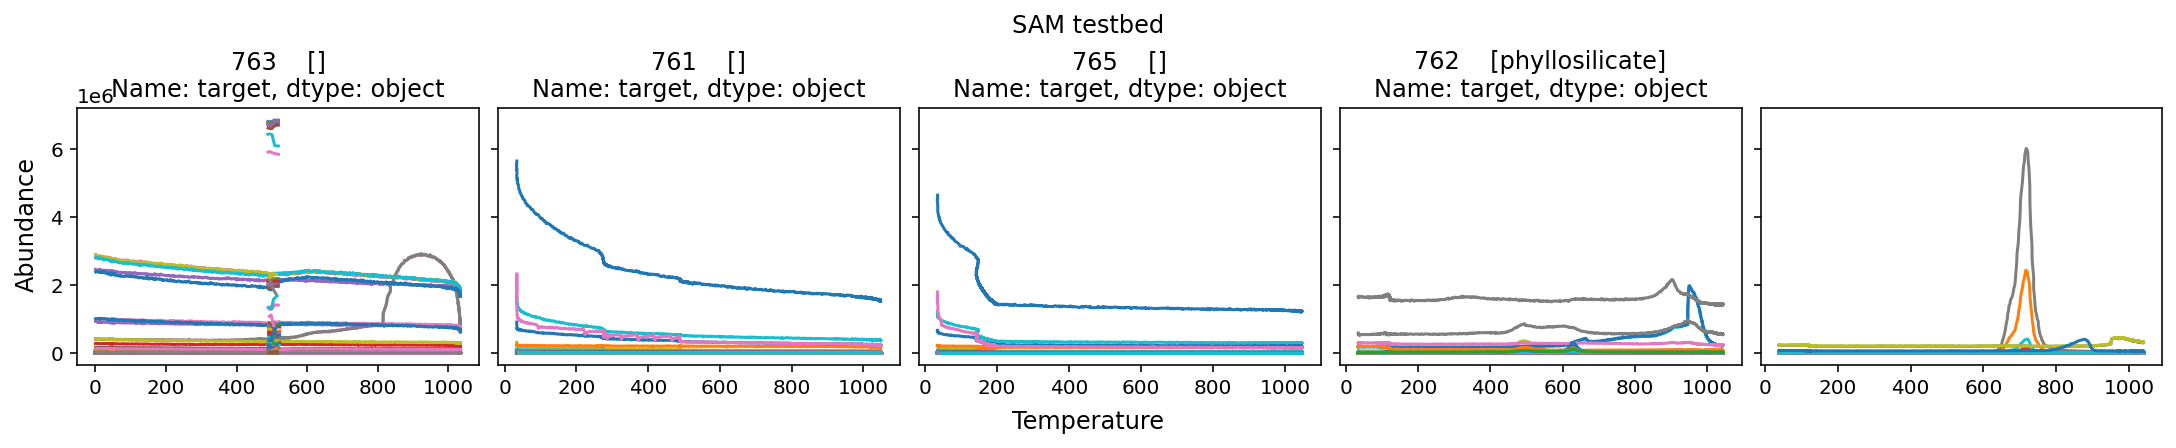

In [14]:
fig, ax = plt.subplots(1, len(sample_com), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Abundance')
fig.supxlabel('Temperature')
fig.suptitle('Commercial')

for n,i in enumerate(sample_com):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    target = train_labels[train_labels.sample_id == sample_name]['target']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    for i in df['m/z'].unique():
        ht = df[df['m/z'] == i]
        plt.plot(ht['temp'], ht['abundance'])
    plt.title(str(target))
plt.show()

del ht

fig, ax = plt.subplots(1, len(sample_sam), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Abundance')
fig.supxlabel('Temperature')
fig.suptitle('SAM testbed')

for n,i in enumerate(sample_sam):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    target = train_labels[train_labels.sample_id == sample_name]['target']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    for i in df['m/z'].unique():
        ht = df[df['m/z'] == i]
        plt.plot(ht['temp'], ht['abundance'])
    plt.title(str(target))
plt.show()
    

Plot the average abundance per type of ions `m/z`.

In [ ]:
#TODO Add labels for ion types greater than some value
#TODO How ions compare to the helium carrier gas

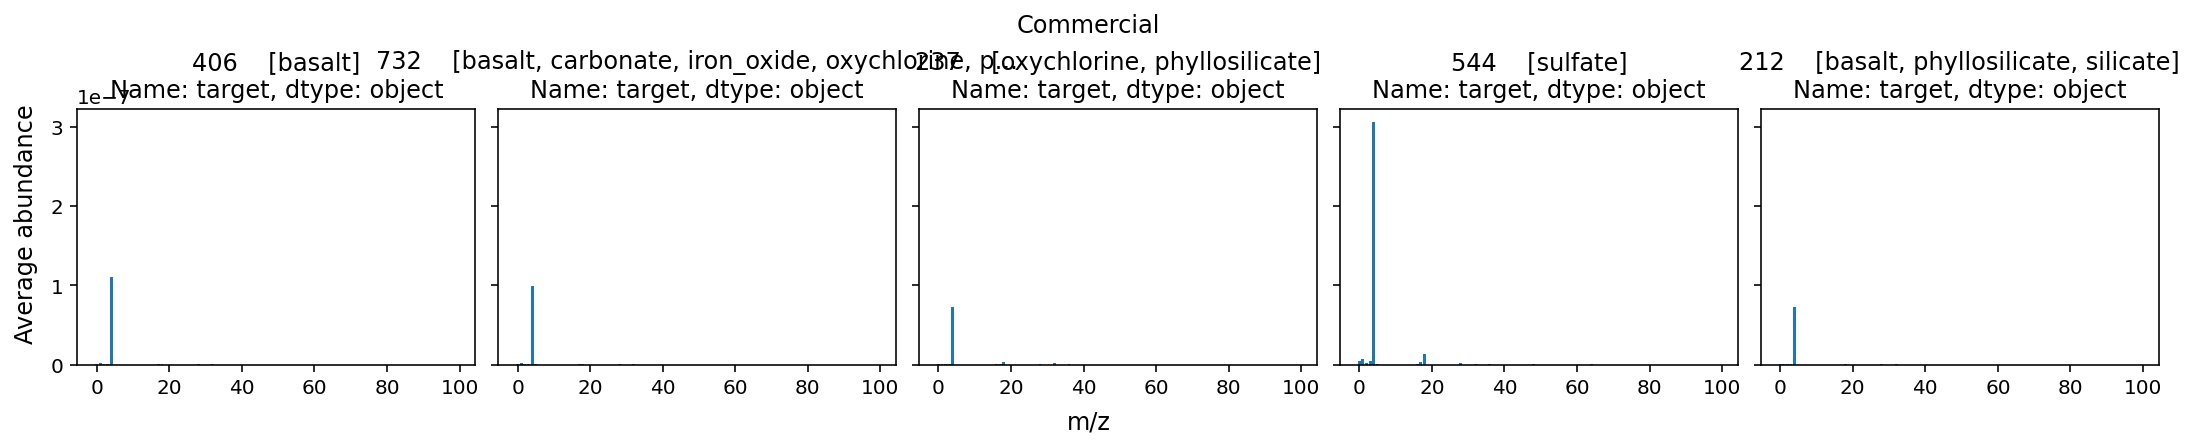

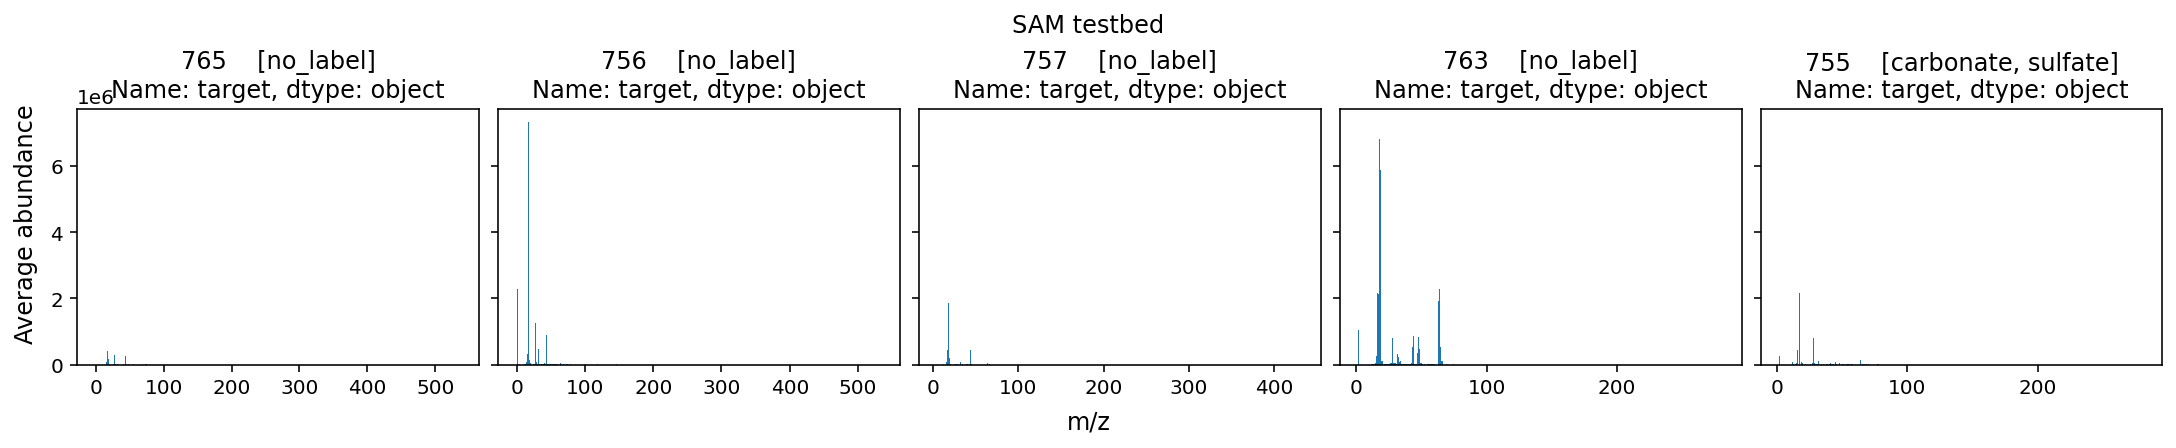

In [ ]:
fig, ax = plt.subplots(1, len(sample_com), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Average abundance')
fig.supxlabel('m/z')
fig.suptitle('Commercial')

for n,i in enumerate(sample_com):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    target = train_labels[train_labels.sample_id == sample_name]['target']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    abd_sum = pd.DataFrame(df.groupby('m/z')['abundance'].agg('mean')).reset_index()
    plt.bar(abd_sum['m/z'], abd_sum['abundance'])
    plt.title(str(target))
plt.show()

fig, ax = plt.subplots(1, len(sample_sam), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Average abundance')
fig.supxlabel('m/z')
fig.suptitle('SAM testbed')

for n,i in enumerate(sample_sam):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    target = train_labels[train_labels.sample_id == sample_name]['target']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    abd_sum = pd.DataFrame(df.groupby('m/z')['abundance'].agg('mean')).reset_index()
    plt.bar(abd_sum['m/z'], abd_sum['abundance'])
    plt.title(str(target))
plt.show()
    

`m/z` values (from the benchmark notebook):
-  the range is not the same for all samples
- most samples are in the range on (0,99) -> discard m/z with the values above 99
- SAM testbeds samples contain fractional m/z values -> drop them as well
- `m/z=4` corresponds to the helium carrier gas (*A more sophisticated analysis could potentially use it to understand how other ions compare to it relatively.*)

In the following code we compute the range of the `m/z` values for each sample. We can see from the output that the majority of the samples have ion types in the range (0,99). Also, we can see that there are some fractional values and they are close to the integer values.

In [ ]:
NO_SAMPLES = metadata.sample_id.nunique()
print(f'Number of samples = {NO_SAMPLES}')

cnt_mz_sample = {}
for i in range(NO_SAMPLES):
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    df = pd.read_csv(config.DATA_DIR + sample_file)
    cnt_mz_sample[sample_name] = pd.Interval(df['m/z'].min(), df['m/z'].max(), closed='both')
    
metadata['range_mz'] = metadata['sample_id'].map(cnt_mz_sample)

metadata['range_mz'].value_counts()

Number of samples = 1570


[0.0, 99.0]      1211
[0.0, 199.0]      161
[1.0, 60.0]        64
[2.0, 94.0]        48
[1.9, 281.0]       40
[5.0, 433.0]       11
[0.0, 534.0]        7
[0.0, 537.0]        6
[4.0, 64.0]         5
[14.0, 147.0]       3
[2.0, 64.0]         3
[13.9, 147.0]       3
[1.9, 147.0]        2
[5.0, 207.0]        2
[4.0, 78.0]         1
[4.0, 44.0]         1
[26.0, 197.0]       1
[1.9, 150.0]        1
Name: range_mz, dtype: int64

## Slope Analysis

In [78]:
i = 765
# Get data sample
hts = preprocess.get_sample(metadata, i)
hts = preprocess.preprocess_samples(hts)

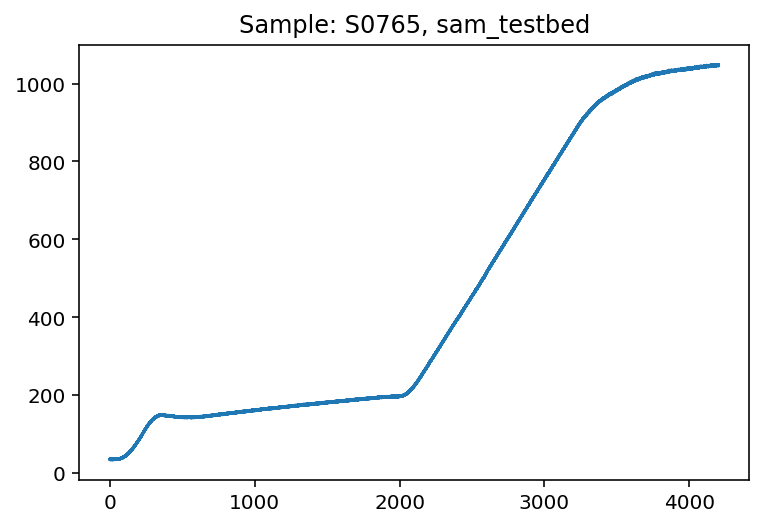

In [79]:
plt.plot(hts['time'], hts['temp'])
plt.title(f'Sample: {metadata.iloc[i]["sample_id"]}, {metadata.iloc[i]["instrument_type"]}')
plt.show()

In [43]:
slope_time_temp = features.slope_time_temp(trva_files, metadata)

100%|██████████| 1059/1059 [01:19<00:00, 13.38it/s]


In [80]:
ht = metadata.iloc[:len(trva_files),:][['sample_id', 'instrument_type']].copy()
ht['slope_tt'] = ht['sample_id'].map(slope_time_temp)
ht.head()

,sample_id,instrument_type,slope_tt
0,S0000,commercial,0.195083
1,S0001,commercial,0.167294
2,S0002,commercial,0.601609
3,S0003,commercial,0.609247
4,S0004,commercial,0.613325


In [81]:
ht.groupby('instrument_type')['slope_tt'].agg('mean')

instrument_type
commercial     0.580422
sam_testbed    0.422096
Name: slope_tt, dtype: float64

In [82]:
ht.groupby('instrument_type')['slope_tt'].agg('median')

instrument_type
commercial     0.608901
sam_testbed    0.500758
Name: slope_tt, dtype: float64

There is a difference in slopes between the two instruments. Let's add this as a feature.

## Target encoding - instrument type

Analyze target encoding based on the instrument type.

In [146]:
ht = metadata[metadata.split.isin(['train', 'val'])][['sample_id','instrument_type']].copy()
ht_y = pd.concat([train_labels, valid_labels], axis = 0).reset_index(drop=True)
assert all(ht.index == ht_y.index)
assert ht_y.shape[0] == ht.shape[0]
temp = pd.merge(ht, ht_y, on='sample_id', how='left')

temp, le_dict = features.label_encode_multi(temp, 'instrument_type', target_labels_list)
temp

,sample_id,instrument_type,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,...,le_basalt,le_carbonate,le_chloride,le_iron_oxide,le_oxalate,le_oxychlorine,le_phyllosilicate,le_silicate,le_sulfate,le_sulfide
0,S0000,commercial,0,0,0,0,0,0,0,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
1,S0001,commercial,0,1,0,0,0,0,0,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
2,S0002,commercial,0,0,0,0,0,1,0,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
3,S0003,commercial,0,1,0,1,0,0,0,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
4,S0004,commercial,0,0,0,1,0,1,1,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,S1054,commercial,0,0,0,0,0,0,0,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
1055,S1055,commercial,0,0,0,0,0,0,0,1,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
1056,S1056,commercial,0,0,0,0,1,0,0,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
1057,S1057,commercial,0,1,0,0,0,0,0,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468


In [150]:
temp['le_carbonate'].value_counts()

0.126074    1047
0.083334      12
Name: le_carbonate, dtype: int64

# Analyze mass Spectrum

In [7]:
i = 737
hts = preprocess.get_sample(metadata, i)
hts = preprocess.preprocess_samples(hts)
sample_name = metadata.iloc[i]['sample_id']

## `oxalate`

https://spectrabase.com/spectrum/DHc77L5NLkT

In [21]:
oxalate = train_labels[train_labels['oxalate'] == 1].index


100%|██████████| 30/30 [00:07<00:00,  4.16it/s]


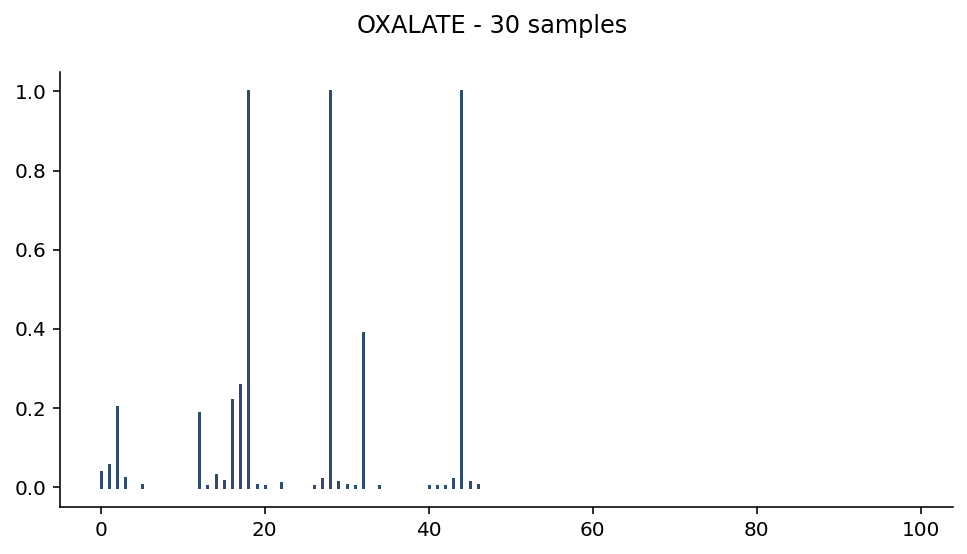

In [22]:
_,_ = plt.subplots(1,1, figsize=(8,4))
plt.suptitle(f'OXALATE - {len(oxalate)} samples')
for i in tqdm(oxalate):
    hts = preprocess.get_sample(metadata, i)
    hts = preprocess.preprocess_samples(hts)
    sample_name = metadata.iloc[i]['sample_id']
    # List of ions present in the sample
    ion_list = hts['m/z'].unique().tolist()
    for ion in ion_list:
        temp = hts[hts['m/z'] == ion]
        y = temp['abun_minsub_scaled'].max()
        plt.plot([ion,ion], [0,y], c='#2D4B73')
sns.despine()
plt.show()

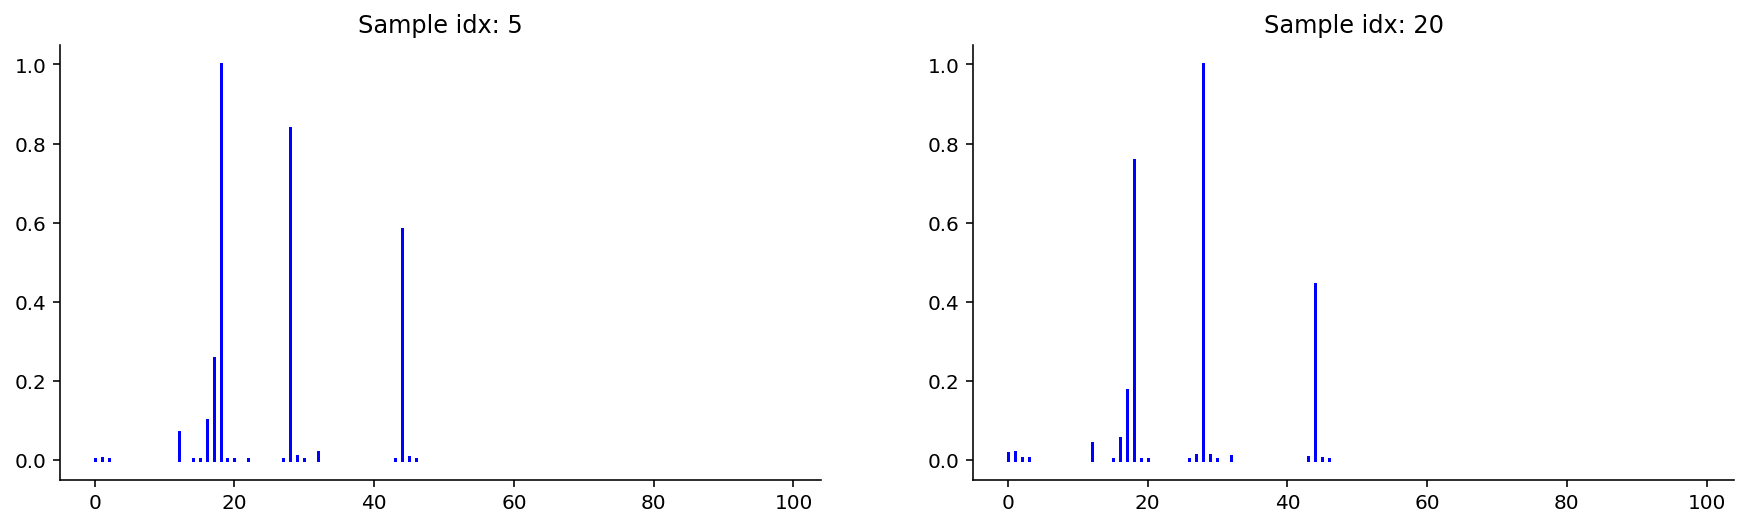

In [37]:
no_plots = 2
_,_ = plt.subplots(1,no_plots, figsize=(15,4))
for n in range(no_plots):
    
    i = oxalate[n]
    
    # Get data sample
    hts = preprocess.get_sample(metadata, i)
    hts = preprocess.preprocess_samples(hts)

    max_abund_ion = {}
    for ion in ion_list:
        temp = hts[hts['m/z'] == ion]
        max_abund_ion[ion] = temp['abun_minsub_scaled'].max()
    
    # Sample median of abundance
    #abund_median = hts['abun_minsub_scaled'].mean()
    
    plt.subplot(1,no_plots,n+1)
    plt.title(f'Sample idx: {i}')
    #[mz,mz],[0,peak]
    for ion in ion_list:
        y = max_abund_ion[ion]
        plt.plot([ion,ion], [0,y], c='blue')
    #plt.plot([0,100], [abund_median, abund_median], c='orange')
    sns.despine()
plt.show()

## `basalt`

In [44]:
basalt = train_labels[train_labels['basalt'] == 1].index
basalt


Int64Index([ 16,  21,  26,  28,  30,  35,  45,  73,  84,  91,  99, 100, 107,
            109, 112, 117, 122, 133, 149, 153, 159, 163, 171, 174, 177, 181,
            208, 211, 212, 215, 220, 223, 233, 242, 251, 253, 266, 271, 281,
            282, 289, 303, 322, 324, 329, 334, 385, 403, 406, 422, 438, 454,
            459, 462, 464, 474, 489, 491, 500, 507, 509, 514, 517, 521, 534,
            541, 546, 573, 574, 577, 580, 595, 597, 606, 612, 618, 624, 635,
            647, 649, 653, 655, 674, 682, 703, 707, 720, 722, 729, 732, 753],
           dtype='int64')

100%|██████████| 91/91 [00:27<00:00,  3.33it/s]


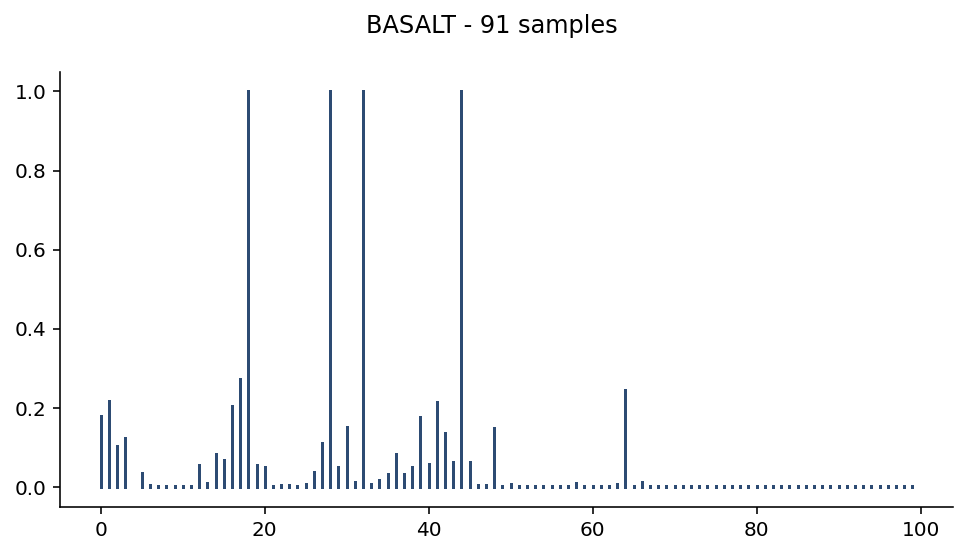

In [20]:
_,_ = plt.subplots(1,1, figsize=(8,4))
plt.suptitle(f'BASALT - {len(basalt)} samples')
for i in tqdm(basalt):
    hts = preprocess.get_sample(metadata, i)
    hts = preprocess.preprocess_samples(hts)
    sample_name = metadata.iloc[i]['sample_id']
    # List of ions present in the sample
    ion_list = hts['m/z'].unique().tolist()
    for ion in ion_list:
        temp = hts[hts['m/z'] == ion]
        y = temp['abun_minsub_scaled'].max()
        plt.plot([ion,ion], [0,y], c='#2D4B73')
sns.despine()
plt.show()

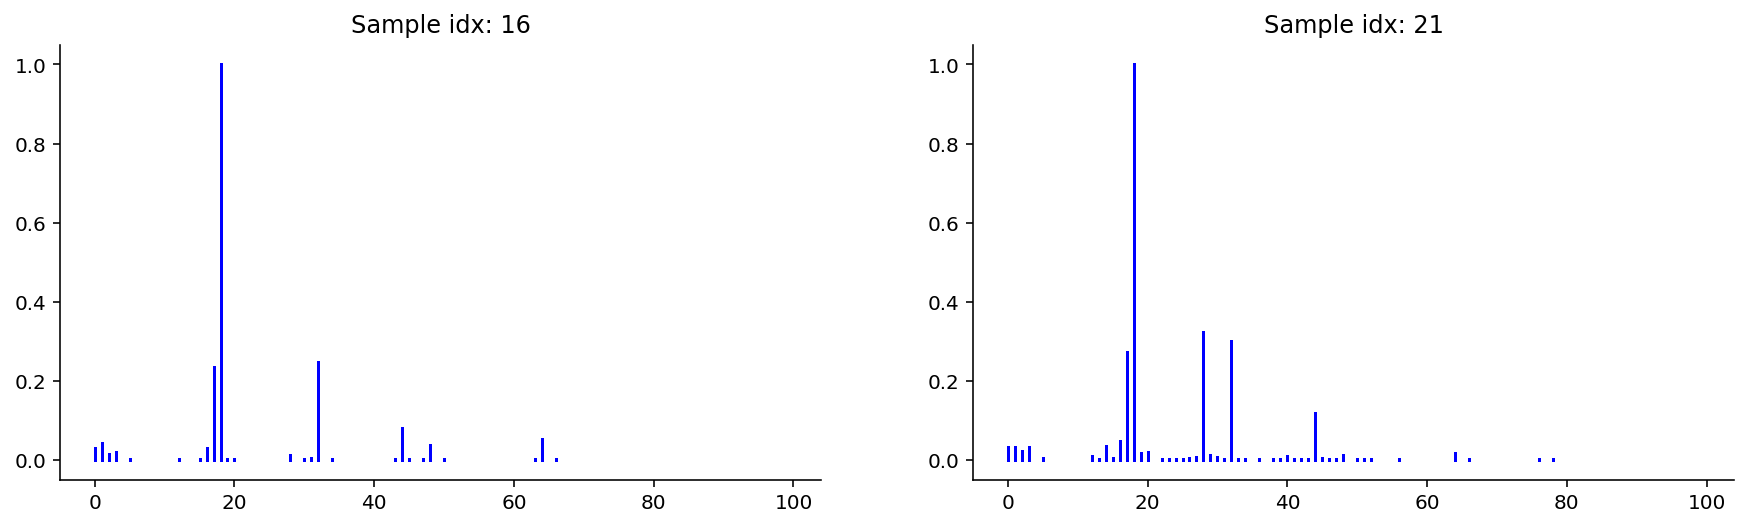

In [77]:
no_plots = 2
_,_ = plt.subplots(1,no_plots, figsize=(15,4))
for n in range(no_plots):
    
    i = basalt[n]
    
    # Get data sample
    hts = preprocess.get_sample(metadata, i)
    hts = preprocess.preprocess_samples(hts)

    max_abund_ion = {}
    for ion in ion_list:
        temp = hts[hts['m/z'] == ion]
        max_abund_ion[ion] = temp['abun_minsub_scaled'].max()
    
    # Sample median of abundance
    #abund_median = hts['abun_minsub_scaled'].mean()
    
    plt.subplot(1,no_plots,n+1)
    plt.title(f'Sample idx: {i}')
    #[mz,mz],[0,peak]
    for ion in ion_list:
        y = max_abund_ion[ion]
        plt.plot([ion,ion], [0,y], c='blue')
    #plt.plot([0,100], [abund_median, abund_median], c='orange')
    sns.despine()
plt.show()

In [75]:
hts = preprocess.get_sample(metadata, 20)
hts = preprocess.preprocess_samples(hts)
print(hts[hts['m/z'] == 0.0]['abun_minsub_scaled'].max())
list((hts.groupby('m/z')['abun_minsub_scaled'].agg('max').sort_values(ascending=False)).head(3).index)

0.017149621845516435


[28.0, 18.0, 44.0]

# TOP N ions based on max relative abundance

In [15]:
top3_ions = features.get_topN_ions(metadata, N=3)
top3_ions.head()

100%|██████████| 1570/1570 [01:54<00:00, 13.72it/s]


,top_1,top_2,top_3
S0000,0.18,0.17,0.16
S0001,0.44,0.16,0.02
S0002,0.18,0.32,0.17
S0003,0.18,0.44,0.17
S0004,0.18,0.32,0.17


In [16]:
print(list(top3_ions.top_1.unique()))

[0.18, 0.43999999999999995, 0.32, 0.27999999999999997, 0.64, 0.02, 0.3, 0.0, 0.16999999999999998, 0.43, 0.26999999999999996]


In [17]:
temp = top3_ions.iloc[:train.shape[0],:].copy()
temp = pd.concat([temp, train_labels.set_index('sample_id')], axis = 1)
temp.head()

,top_1,top_2,top_3,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
S0000,0.18,0.17,0.16,0,0,0,0,0,0,0,0,1,0
S0001,0.44,0.16,0.02,0,1,0,0,0,0,0,0,0,0
S0002,0.18,0.32,0.17,0,0,0,0,0,1,0,0,0,0
S0003,0.18,0.44,0.17,0,1,0,1,0,0,0,0,1,0
S0004,0.18,0.32,0.17,0,0,0,1,0,1,1,0,0,0


In [18]:
temp = temp.drop(['top_2', 'top_3'], axis = 1)
tempm = pd.melt(temp, id_vars='top_1', value_vars=target_labels_list)
tempm = tempm[tempm.value == 1]

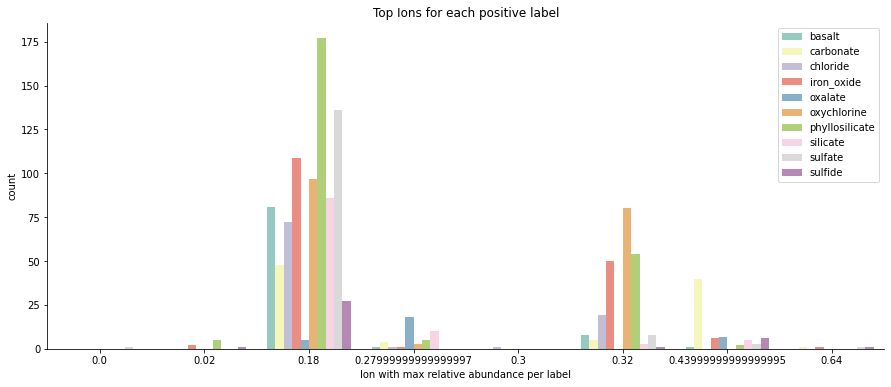

In [19]:
_,_ = plt.subplots(1,1,figsize=(15,6))
sns.countplot(x='top_1', data=tempm, hue='variable', palette="Set3")
plt.title('Top Ions for each positive label')
plt.xlabel('Ion with max relative abundance per label')
plt.legend()
sns.despine()
plt.show()

# Target encoding for top ions

- Separate for instruments

In [20]:
temp = top3_ions.iloc[:train.shape[0],:].copy()
temp = pd.concat([temp, train_labels.set_index('sample_id')], axis = 1)
print(temp.shape)
temp.head()

(766, 13)


,top_1,top_2,top_3,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
S0000,0.18,0.17,0.16,0,0,0,0,0,0,0,0,1,0
S0001,0.44,0.16,0.02,0,1,0,0,0,0,0,0,0,0
S0002,0.18,0.32,0.17,0,0,0,0,0,1,0,0,0,0
S0003,0.18,0.44,0.17,0,1,0,1,0,0,0,0,1,0
S0004,0.18,0.32,0.17,0,0,0,1,0,1,1,0,0,0


In [21]:
# TOP = 1
df = pd.DataFrame(index=list(temp.top_1.unique()))
for label in target_labels_list:
    le = features.label_encode(temp, 'top_1', label)
    df = pd.concat([df, le], axis=1, ignore_index=False)
cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm, axis = 1)

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
0.180000,0.153992,0.091255,0.136882,0.207224,0.009506,0.184411,0.336502,0.163498,0.258555,0.051331
0.440000,0.017544,0.701754,0.000000,0.105263,0.122807,0.000000,0.035088,0.087719,0.052632,0.105263
0.320000,0.067227,0.042017,0.159664,0.420168,0.000000,0.672269,0.453782,0.025210,0.067227,0.008403
0.280000,0.020408,0.081633,0.020408,0.020408,0.367347,0.061224,0.102041,0.204082,0.000000,0.000000
0.640000,0.031950,0.399937,0.032652,0.424865,0.010533,0.063198,0.085317,0.036514,0.417843,0.378169
0.020000,0.000015,0.000016,0.000015,0.200003,0.000005,0.000029,0.499977,0.000017,0.000024,0.099993
0.300000,0.059399,0.063969,0.560705,0.110313,0.019582,0.117493,0.158616,0.067885,0.097258,0.023499
0.000000,0.059399,0.063969,0.060705,0.110313,0.019582,0.117493,0.158616,0.067885,0.597258,0.023499
0.170000,0.059399,0.063969,0.060705,0.110313,0.019582,0.117493,0.158616,0.067885,0.097258,0.023499


In [22]:
# TOP = 2
df = pd.DataFrame(index=list(temp.top_2.unique()))
for label in target_labels_list:
    le = features.label_encode(temp, 'top_2', label)
    df = pd.concat([df, le], axis=1, ignore_index=False)
cm = sns.light_palette("blue", as_cmap=True)
df.style.background_gradient(cmap=cm, axis = 1)

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
0.170000,0.125000,0.071970,0.151515,0.193182,0.000000,0.087121,0.356061,0.090909,0.325758,0.018939
0.160000,0.080000,0.420000,0.060000,0.120000,0.000000,0.500000,0.200000,0.060000,0.060000,0.040000
0.320000,0.200000,0.133333,0.158974,0.215385,0.000000,0.343590,0.343590,0.276923,0.138462,0.061538
0.440000,0.166667,0.095238,0.023810,0.119048,0.166667,0.119048,0.309524,0.166667,0.214286,0.023810
0.280000,0.090909,0.386364,0.022727,0.136364,0.250000,0.068182,0.090909,0.068182,0.113636,0.000000
0.020000,0.000000,0.045455,0.000000,0.272727,0.000000,0.000000,0.272727,0.272727,0.000000,0.090909
0.180000,0.033613,0.058824,0.126050,0.394958,0.100840,0.470588,0.411765,0.042017,0.050420,0.050420
0.640000,0.000000,0.000000,0.000000,0.333333,0.000000,0.066667,0.000000,0.000000,0.533333,0.466666
0.120000,0.059399,0.063969,0.060705,0.110313,0.019582,0.117493,0.158616,0.567885,0.097258,0.023499
0.010000,0.000795,0.331959,0.000813,0.001477,0.000262,0.001573,0.002123,0.000909,0.001302,0.000315


In [23]:
# TOP = 3
df = pd.DataFrame(index=list(temp.top_2.unique()))
for label in target_labels_list:
    le = features.label_encode(temp, 'top_3', label)
    df = pd.concat([df, le], axis=1, ignore_index=False)
cm = sns.light_palette("orange", as_cmap=True)
df.style.background_gradient(cmap=cm, axis = 1)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/pandas/io/formats/style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
0.170000,0.151220,0.082927,0.151220,0.239024,0.000000,0.351220,0.341463,0.151220,0.141463,0.068293
0.160000,0.021739,0.304348,0.130435,0.304348,0.000000,0.391304,0.369565,0.021739,0.173913,0.043478
0.320000,0.163265,0.096939,0.163265,0.188776,0.010204,0.107143,0.392857,0.117347,0.285714,0.005102
0.440000,0.182927,0.182927,0.097561,0.365854,0.195122,0.304878,0.475610,0.207317,0.182927,0.024390
0.280000,0.012658,0.240506,0.063291,0.164557,0.012658,0.139241,0.240506,0.113924,0.063291,0.113924
0.020000,0.002137,0.395107,0.002184,0.003968,0.000704,0.004227,0.398511,0.198845,0.003499,0.000845
0.180000,0.074074,0.129630,0.092593,0.185185,0.203704,0.388889,0.259259,0.148148,0.055556,0.018519
0.640000,0.125000,0.041667,0.000000,0.208333,0.000000,0.041667,0.041667,0.083333,0.666667,0.166667
0.120000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0.010000,0.060606,0.090909,0.030303,0.090909,0.000000,0.121212,0.060606,0.242424,0.272727,0.000000


In [126]:
import os

In [ ]:
combo_maxabund_peaks_slope_VT.to_csv(os.path.join(config.DATA_DIR_OUT + 'combo_maxabund_peaks_slope_VT.csv'), 
                                  index=False)

In [76]:
# TRAIN ONLY
combo_maxabund_peaks_slope = pd.read_csv(os.path.join(config.DATA_DIR_OUT + 'combo_maxabund_peaks_slope.csv'))
combo_maxabund_peaks_slope_VT = pd.read_csv(os.path.join(config.DATA_DIR_OUT + 'combo_maxabund_peaks_slope_VT.csv'))
combo_maxabund_peaks_slope.head()
print(combo_maxabund_peaks_slope.shape)

(766, 1981)


# Correlation between ions

In [22]:
i = 0
hts = preprocess.get_sample(metadata, i)
hts = preprocess.preprocess_samples(hts)

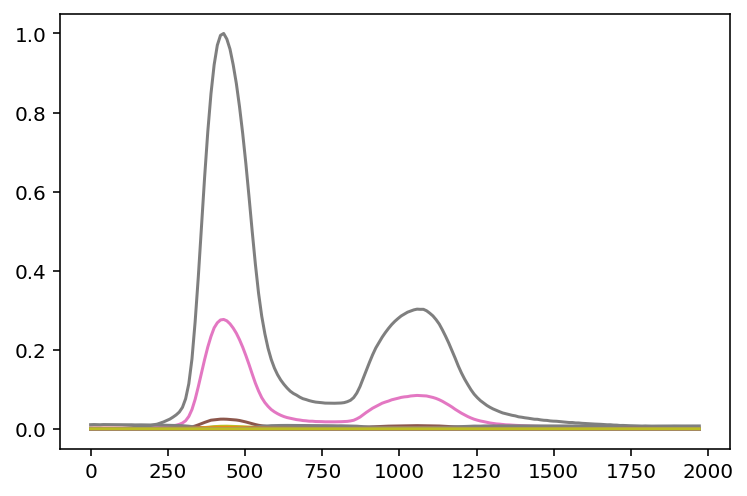

In [14]:
describe_data.plot_ions(hts)

In [18]:
all(hts[hts['m/z'] == 18.0]['time'].values == hts[hts['m/z'] == 17.0]['time'].values)

True

In [21]:
hts.sort_values(by=['m/z', 'time']).drop('temp', axis=1).melt(id_vars='time', )

,time,m/z,abun_minsub_scaled
0,0.000,0.0,0.000172
200,10.251,0.0,0.000182
400,20.519,0.0,0.000158
600,30.791,0.0,0.000184
800,41.044,0.0,0.000170
...,...,...,...
37699,1930.577,99.0,0.000003
37899,1940.860,99.0,0.000002
38099,1951.118,99.0,0.000003
38299,1961.391,99.0,0.000002


In [9]:
hts.head(2)

,time,temp,m/z,abun_minsub_scaled
0,0.00,53.283,34.0,0.000038
1,0.23,53.284,35.0,0.000003


In [308]:
df_corr = corr_peak_mz(hts)

Number of ions: 99


In [309]:
suffix = ".0"
df_corr.columns = [str(i).removesuffix(suffix) for i in df_corr]
df_corr.index = [str(i).removesuffix(suffix) for i in df_corr.index]

In [317]:
df = df_corr[df_corr.apply(lambda x: np.abs(x) > 0.6, axis=0) == True].dropna()

In [316]:
df_corr[df_corr.Ion_18 > 0.6]

,Ion_18,Ion_17
0,0.950994,0.949201
1,0.963499,0.961934
2,0.903654,0.903474
5,0.682479,0.680486
15,0.908979,0.908438
16,0.995825,0.995605
17,0.999452,1.000000
18,1.000000,0.999452
19,0.926628,0.928444
20,0.981610,0.981334


In [318]:
#cm = sns.light_palette("blue", as_cmap=True)
df.style.background_gradient(cmap='coolwarm').format(precision=3)

,Ion_18,Ion_17
0,0.951,0.949
1,0.963,0.962
2,0.904,0.903
5,0.682,0.680
14,-0.799,-0.802
15,0.909,0.908
16,0.996,0.996
17,0.999,1.000
18,1.000,0.999
19,0.927,0.928


In [19]:
df_proba = metadata.iloc[:10,:].copy()
df_proba

,sample_id,split,instrument_type,features_path,features_md5_hash
0,S0000,train,commercial,train_features/S0000.csv,017b9a71a702e81a828e6242aa15f049
1,S0001,train,commercial,train_features/S0001.csv,0d09840214054d254bd49436c6a6f315
2,S0002,train,commercial,train_features/S0002.csv,3f58b3c9b001bfed6ed4e4f757083e09
3,S0003,train,commercial,train_features/S0003.csv,e9a12f96114a2fda60b36f4c0f513fb1
4,S0004,train,commercial,train_features/S0004.csv,b67603d3931897bfa796ac42cc16de78
5,S0005,train,commercial,train_features/S0005.csv,284487f9c43263e4c5a8ca04a0f4b8d8
6,S0006,train,commercial,train_features/S0006.csv,af79f0aa812908eb82f43d71462cc71e
7,S0007,train,commercial,train_features/S0007.csv,09f5325dd9d2a3b08d71c192a03a4db8
8,S0008,train,commercial,train_features/S0008.csv,335546d46997611784f504431753d94f
9,S0009,train,commercial,train_features/S0009.csv,24d74c12eb1486c9fcd90d27e15abbdf


In [40]:
#ions_corr = features.corr_ions_sig(metadata)

 26%|██▌       | 401/1570 [02:22<06:56,  2.81it/s]


In [ ]:
len(ions_corr)

60

**Do we want negative correlation in here?**

# Euclidean distance between ions

In [125]:
i = 0
hts = preprocess.get_sample(metadata, i)
hts = preprocess.preprocess_samples(hts)

targets = train_labels.iloc[0,:]
targets = targets[targets == 1].index

In [20]:
# Check that the length of all ion time series is equal
assert len(hts.groupby('m/z')['time'].agg('count').unique()) == 1

# They do differ across samples, but not within one sample !!!

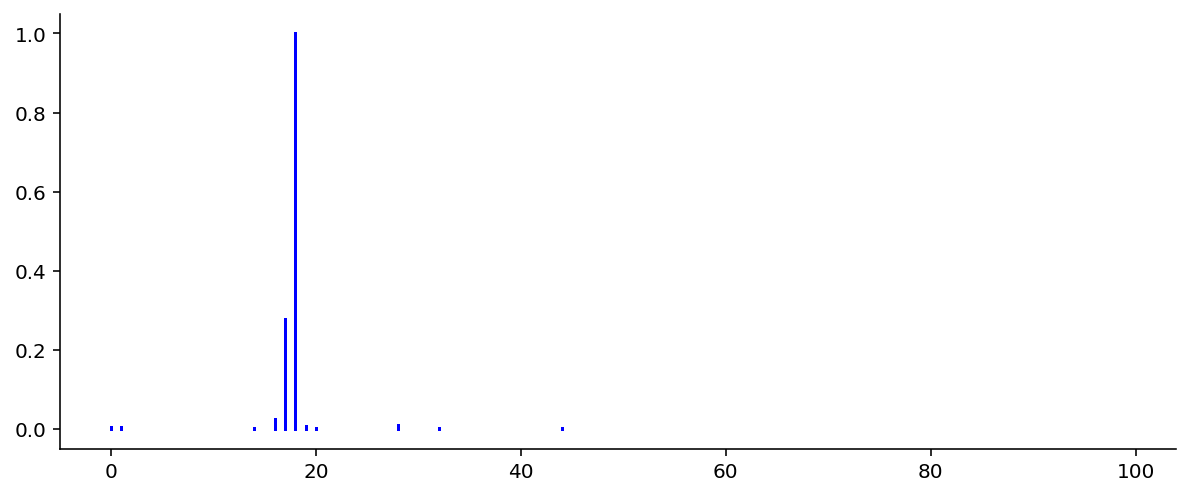

In [24]:
_,_ = plt.subplots(1,1, figsize=(10,4))
max_abund_ion = {}
for ion in ion_list:
    temp = hts[hts['m/z'] == ion]
    max_abund_ion[ion] = temp['abun_minsub_scaled'].max()

# Sample median of abundance
#abund_median = hts['abun_minsub_scaled'].mean()
#[mz,mz],[0,peak]
for ion in ion_list:
    y = max_abund_ion[ion]
    plt.plot([ion,ion], [0,y], c='blue')
#plt.plot([0,100], [abund_median, abund_median], c='orange')
sns.despine()
plt.show()

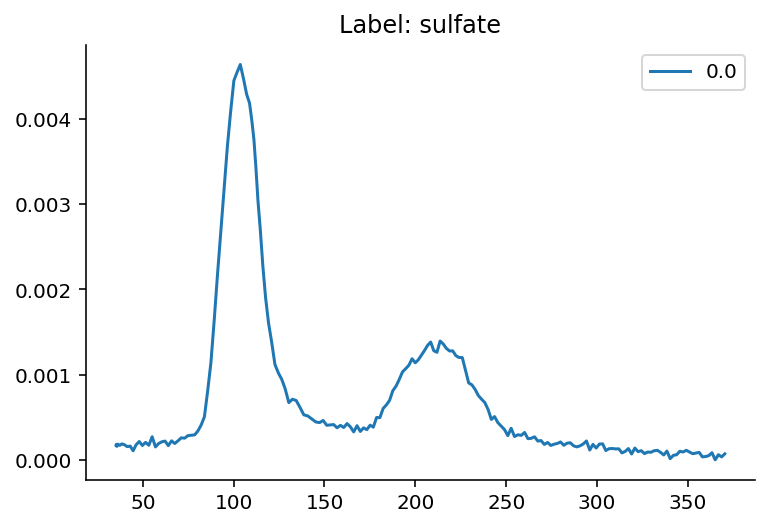

In [116]:
for i in [0.0]:
    ht = hts[hts['m/z'] == i]
    plt.plot(ht['temp'], ht['abun_minsub_scaled'], label=i)
plt.legend()
plt.title(f'Label: {targets[0]}')
sns.despine()
plt.show()

In [66]:
t18 = hts[hts['m/z'] == 18.0]['abun_minsub_scaled'].values
t17 = hts[hts['m/z'] == 17.0]['abun_minsub_scaled'].values
t0 = hts[hts['m/z'] == 0.0]['abun_minsub_scaled'].values

In [115]:
# Values mesure in same time intervals for two ions
all(hts[hts['m/z'] == 18.0]['time'].values == hts[hts['m/z'] == 17.0]['time'].values)

True

In [28]:
sample_ions = list(hts['m/z'].unique())
print(sample_ions)

[0.0, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0]


In [35]:
def euclid_dist(t1,t2):
    return np.sqrt(sum((t1-t2)**2))

In [80]:
def compute_abd_dist(df_sample):
    """
    Compute distance of abundance between ions.
    Disregarding the time matching.
    """
    
    # Check that the length of all ion time series is equal
    assert len(df_sample.groupby('m/z')['time'].agg('count').unique()) == 1

    # Get the ion list
    sample_ions = list(df_sample['m/z'].unique())
    print(f'Number of ions: {len(sample_ions)}')
    
    df_distances = pd.DataFrame(index=sample_ions, columns=sample_ions)
    
    for i in sample_ions:
        print(i)
        ion_i = df_sample[df_sample['m/z'] == i]['abun_minsub_scaled'].values
        for j in sample_ions:
            print(j)
            ion_j = df_sample[df_sample['m/z'] == j]['abun_minsub_scaled'].values
            dist = euclid_dist(ion_i, ion_j)
            df_distances.loc[i,j] = dist
    
    return df_distances

In [85]:
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import find_peaks

def get_peaks(df_sample):
    # Get the ion list
    sample_ions = list(df_sample['m/z'].unique())
    
    # Compute stats and save in dict for each ion type
    ion_peaks_cnt = {} # Initialize dictionary to save calculated values
    for ion in sample_ions:        
        temp_dt = df_sample[df_sample['m/z'] == ion].copy()
        
        # Apply Gaussian filter for the values
        temp_dt['abun_minsub_scaled_filtered'] = gaussian_filter1d(temp_dt['abun_minsub_scaled'], 
                                                                sigma=4)
        
        # Compute the median for the prominence ("the minimum height necessary 
        # to descend to get from the summit to any higher terrain")
        med = temp_dt['abun_minsub_scaled_filtered'].median()
        
        # Find peaks
        peaks, _ = find_peaks(temp_dt['abun_minsub_scaled_filtered'], 
                              prominence=med)
        ion_peaks_cnt[ion].append(len(peaks))
        
    return peaks

In [104]:
def compute_abd_dist_peak(df_sample):
    """
    Compute distance of abundance between ions.
    Disregarding the time matching.
    """
    
    # Check that the length of all ion time series is equal
    assert len(df_sample.groupby('m/z')['time'].agg('count').unique()) == 1

    # Get the ion list
    sample_ions = list(df_sample['m/z'].unique())
    print(f'Number of ions: {len(sample_ions)}')
    
    ion_i = df_sample[df_sample['m/z'] == 18.0]['abun_minsub_scaled'].values
    
    df_distances = pd.DataFrame(index=sample_ions)
    
    for j in sample_ions:
        ion_j = df_sample[df_sample['m/z'] == j]['abun_minsub_scaled'].values
        
        # Values mesured in same time intervals for two ions
        all(ion_i['time'].values == ion_j['time'].values)

        dist = euclid_dist(ion_i, ion_j)
        df_distances.loc[j,'Ion_18'] = dist
    
    return df_distances

In [81]:
df_dst = compute_abd_dist(hts)

Number of ions: 99
0.0
0.0
1.0
2.0
3.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
1.0
0.0
1.0
2.0
3.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
2

In [105]:
df_dst = compute_abd_dist_peak(hts)
df_dst

Number of ions: 99


,Ion_18
0.0,3.800007
1.0,3.802072
2.0,3.815103
3.0,3.816544
5.0,3.817147
...,...
95.0,3.817283
96.0,3.817278
97.0,3.817283
98.0,3.817284


(3.8, 3.82)

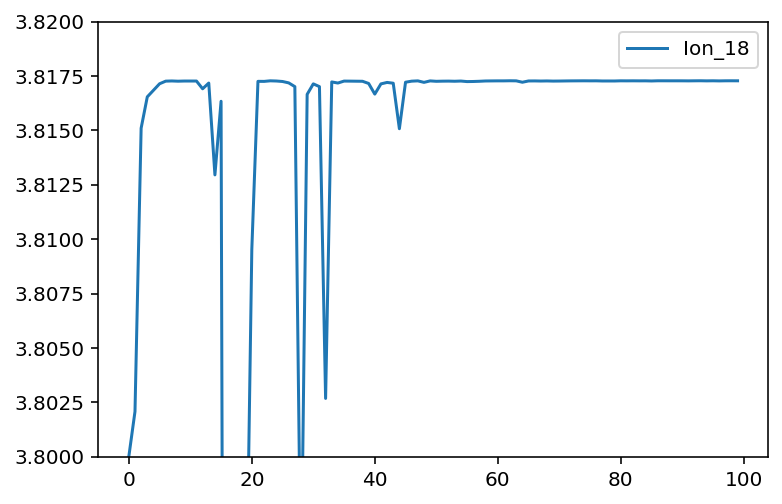

In [111]:
df_dst[~df_dst.index.isin([18.0, 17.0])].plot()
plt.ylim(3.80,3.82)

In [108]:
#TODO COmpare this with PCA on this sample only

In [84]:
df_dst.loc[18.0,0
           .0]

3.8000068974448276

In [71]:
euclid_dist(t18, t17)

2.7606458226249817

In [67]:
euclid_dist(t18, t0)

3.8000068974448276

# Dynamic Time Warping

In [74]:
def DTWDistance(s1, s2):
    DTW={}
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

print(DTWDistance(t18,t0))

3.7829200465482664
